In [5]:
# Importa as bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from google.colab import drive

In [6]:
# Monta o Google Drive para acesso aos arquivos
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Carrega dados auxiliares
municipios_df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/API1S/UF_MUN.csv",
    delimiter=';',
    encoding='latin-1'
)
municipios_df.columns = municipios_df.columns.str.strip()

ncm_sh_df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/API1S/NCM_SH.csv",
    delimiter=';',
    encoding='latin-1'
)

In [8]:
# Função corrigida para carregar dados
def carregar_dados():
    dados = {}
    anos = ['2019', '2020', '2021', '2022', '2023', '2024']

    for ano in anos:
        # Carrega e trata os dados
        df = pd.read_csv(
            f"/content/drive/MyDrive/Colab Notebooks/API1S/EXP_{ano}_MUN.csv",
            delimiter=';',
            dtype={'KG_LIQUIDO': str, 'VL_FOB': str}  # Garante leitura como string
        )
        df.columns = df.columns.str.strip()

        # Filtra municípios de SP
        df_sp = df[df['SG_UF_MUN'].str.contains('SP', na=False)].copy()

        # Converte valores numéricos
        df_sp['KG_LIQUIDO'] = pd.to_numeric(
            df_sp['KG_LIQUIDO'].str.replace(',', '.', regex=False),
            errors='coerce'
        )
        df_sp['VL_FOB'] = pd.to_numeric(
            df_sp['VL_FOB'].str.replace(',', '.', regex=False),
            errors='coerce'
        )

        dados[ano] = df_sp

    return dados

In [9]:
# Carrega os dados corrigidos
dados_ano = carregar_dados()

In [10]:
# Prepara lista de municípios de SP
municipios_sp = municipios_df[municipios_df['CO_MUN_GEO'].isin(dados_ano['2020']['CO_MUN'].unique())]
municipios_sp_list = sorted(municipios_sp['NO_MUN'].unique().tolist())

In [11]:
# Widgets atualizados
ano_dropdown = widgets.Dropdown(
    options=['2019', '2020', '2021', '2022', '2023', '2024'],
    value='2020',
    description='Ano:'
)

municipios_dropdown = widgets.Dropdown(
    options=municipios_sp_list,
    value=municipios_sp_list[0],
    description='Município:'
)

metrica_dropdown = widgets.Dropdown(
    options=['Kilos', 'Valor Agregado'],
    value='Kilos',
    description='Métrica:'
)

top5_button = widgets.Button(
    description='Mostrar Top 5 Municípios',
    button_style='info'
)

In [12]:
# Funções gráficas atualizadas
def criar_grafico(dados, municipio, ano):
    clear_output(wait=True)
    display(ano_dropdown, municipios_dropdown, metrica_dropdown, top5_button)

    df_ano = dados[ano]
    metrica = metrica_dropdown.value

    if metrica == 'Kilos':
        coluna = 'KG_LIQUIDO'
        df_metricas = df_ano.groupby(['CO_MUN', 'SH4'])[coluna].sum().reset_index()
    else:
        df_metricas = df_ano.groupby(['CO_MUN', 'SH4']).agg(
            Total_FOB=('VL_FOB', 'sum'),
            Total_KG=('KG_LIQUIDO', 'sum')
        ).reset_index()
        df_metricas['Valor_Agregado'] = df_metricas['Total_FOB'] / df_metricas['Total_KG']
        coluna = 'Valor_Agregado'

    top5 = df_metricas.groupby('CO_MUN').apply(
        lambda x: x.nlargest(5, coluna)
    ).reset_index(drop=True)

    top5 = top5.merge(
        municipios_df[['CO_MUN_GEO', 'NO_MUN']],
        left_on='CO_MUN',
        right_on='CO_MUN_GEO'
    ).merge(
        ncm_sh_df[['CO_SH4', 'NO_SH4_POR']],
        left_on='SH4',
        right_on='CO_SH4'
    )

    top5['Produto'] = top5['NO_SH4_POR'].str[:40] + ' (' + top5['SH4'].astype(str) + ')'
    df_filtrado = top5[top5['NO_MUN'] == municipio]

    plt.figure(figsize=(10, 6))
    plt.barh(df_filtrado['Produto'], df_filtrado[coluna], color='skyblue')
    plt.title(f'Top 5 Produtos - {municipio} ({ano}) - {metrica}')
    plt.xlabel('USD/kg' if metrica == 'Valor Agregado' else 'Kg')
    plt.tight_layout()
    plt.show()

In [15]:
# Função do botão "top 5 municipios que mais exportam em SP"
def criar_grafico_top5(dados, ano):
    clear_output(wait=True)
    display(ano_dropdown, municipios_dropdown, metrica_dropdown, top5_button)

    df_ano = dados[ano]
    metrica = metrica_dropdown.value

    if metrica == 'Kilos':
        df_top = df_ano.groupby('CO_MUN')['KG_LIQUIDO'].sum().reset_index()
    else:
        df_top = df_ano.groupby('CO_MUN').agg(
            Total_FOB=('VL_FOB', 'sum'),
            Total_KG=('KG_LIQUIDO', 'sum')
        ).reset_index()
        df_top['Valor_Agregado'] = df_top['Total_FOB'] / df_top['Total_KG']
        df_top = df_top[['CO_MUN', 'Valor_Agregado']].rename(columns={'Valor_Agregado': 'KG_LIQUIDO'})

    top5 = df_top.nlargest(5, 'KG_LIQUIDO').merge(
        municipios_sp[['CO_MUN_GEO', 'NO_MUN']],
        left_on='CO_MUN',
        right_on='CO_MUN_GEO'
    )

    # Funções gráficas
    plt.figure(figsize=(10, 6))
    plt.barh(top5['NO_MUN'], top5['KG_LIQUIDO'], color='skyblue')
    plt.title(f'Top 5 Municípios ({ano}) - {metrica}')
    plt.xlabel('USD/kg' if metrica == 'Valor Agregado' else 'Kg Totais')
    plt.tight_layout()
    plt.show()

In [17]:
# Event handlers e execução
def on_top5_clicked(b):
    criar_grafico_top5(dados_ano, ano_dropdown.value)

In [18]:
# Função para dar recarregar o gráfico quando selecionado um filtro
def update_graph(change):
    criar_grafico(dados_ano, municipios_dropdown.value, ano_dropdown.value)

In [19]:
# Mais funções gráficas
ano_dropdown.observe(update_graph, names='value')
municipios_dropdown.observe(update_graph, names='value')
metrica_dropdown.observe(update_graph, names='value')
top5_button.on_click(on_top5_clicked)

Dropdown(description='Ano:', index=4, options=('2019', '2020', '2021', '2022', '2023', '2024'), value='2023')

Dropdown(description='Município:', index=357, options=('ADAMANTINA', 'AGUAI', 'AGUAS DE LINDOIA', 'AGUAS DE SA…

Dropdown(description='Métrica:', options=('Kilos', 'Valor Agregado'), value='Kilos')

Button(button_style='info', description='Mostrar Top 5 Municípios', style=ButtonStyle())

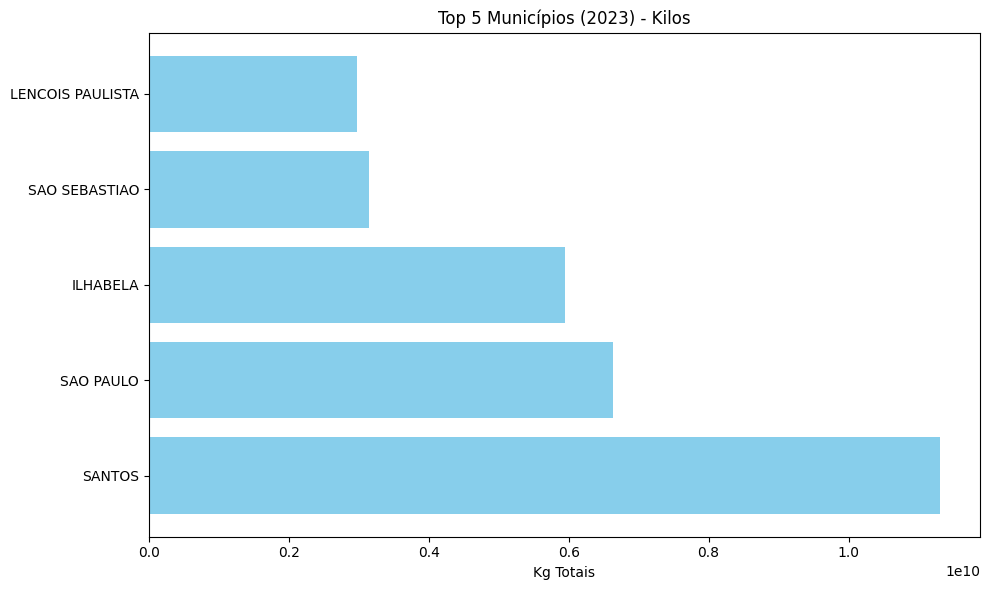

In [20]:
# Exibe o total chamando todas as funções
display(ano_dropdown, municipios_dropdown, metrica_dropdown, top5_button)
criar_grafico(dados_ano, municipios_sp_list[0], '2020')